In [1]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
from data_preprocessing import create_segmentation_datasets

2025-08-10 17:15:57.840569: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-10 17:15:58.633300: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
image_dir = '/home/featurize/data/segmentation_dataset/images'
mask_dir = '/home/featurize/data/segmentation_dataset/masks'

dataset_train, dataset_val, dataset_test = create_segmentation_datasets(image_dir=image_dir, mask_dir=mask_dir, batch_size=24, val_split=0.2, test_split=0.1)

for imgs, masks in dataset_train.take(1):
    print('Train batch images:', imgs.shape, 'masks:', masks.shape)
for imgs, masks in dataset_val.take(1):
    print('Val batch images:', imgs.shape, 'masks:', masks.shape)
for imgs, masks in dataset_test.take(1):
    print('Test batch images:', imgs.shape, 'masks:', masks.shape)

Training samples: 4634, validation samples: 1324, test samples: 662


2025-08-10 17:15:59.510666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-10 17:15:59.514947: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-10 17:15:59.515139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Train batch images: (24, 384, 508, 3) masks: (24, 384, 508, 1)
Val batch images: (24, 384, 508, 3) masks: (24, 384, 508, 1)
Test batch images: (24, 384, 508, 3) masks: (24, 384, 508, 1)


In [4]:
# import tensorflow as tf
# import numpy as np
# from collections import Counter

# def count_classes_in_dataset(dataset):
#     total_counter = Counter()

#     for batch in dataset:
#         images, masks = batch
#         flat_masks = tf.reshape(masks, [-1])
#         result = tf.unique_with_counts(flat_masks)
#         unique_vals = result.y
#         counts = result.count

#         for val, count in zip(unique_vals.numpy(), counts.numpy()):
#             total_counter[int(val)] += int(count)

#     print("\n Dataset 中的类别总分布：")
#     for cls in sorted(total_counter.keys()):
#         print(f"类 {cls}: {total_counter[cls]} 像素")

#     return total_counter

# # 示例调用
# count_classes_in_dataset(dataset_train)

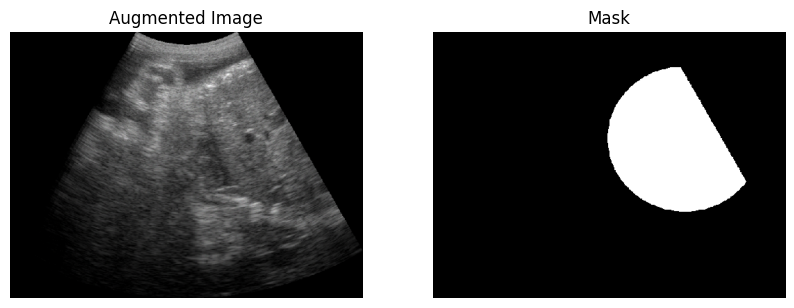

In [5]:
import matplotlib.pyplot as plt
import numpy as np

for img_batch, mask_batch in dataset_train.take(1):
    img = img_batch[0].numpy()
    mask = mask_batch[0].numpy()

    # 1. 将图像从 [-1, 1] 转回 [0, 1] 浮点图像
    img_display = (img + 1.0) / 2.0
    img_display = np.clip(img_display, 0.0, 1.0)

    # 2. 将 mask squeeze，转换为 uint8，用于灰度显示
    mask_display = np.squeeze(mask).astype(np.uint8)

    # 可视化
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img_display, cmap='gray', vmin=0.0, vmax=1.0)  # 显式指定范围
    plt.axis('off')
    plt.title("Augmented Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_display, cmap='gray', vmin=0, vmax=1)  # 确保 0=黑，1=白
    plt.axis('off')
    plt.title("Mask")

    plt.show()


In [6]:
from model_test import model

In [7]:
model = model(img_height=384, img_width=508, classes=2)
model.summary()

*** Output Shape: (None, 384, 508, 2) ***
Model: "ASPP_Only_w_o_Edge"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 384, 508, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 191, 253, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 191, 253, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 191

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# ========= 自定义 Edge-Aware 组合损失 ========= #

def gradient_difference_loss(y_true, y_pred):
    dy_true, dx_true = tf.image.image_gradients(tf.cast(y_true, tf.float32))
    dy_pred, dx_pred = tf.image.image_gradients(tf.cast(y_pred, tf.float32))
    grad_diff_y = tf.abs(dy_pred - dy_true)
    grad_diff_x = tf.abs(dx_pred - dx_true)
    return tf.reduce_mean(grad_diff_y + grad_diff_x)


def dice_loss(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1. - dice


class EdgeAwareLoss:
    def __init__(self, alpha=0.4, beta=0.6, gamma=2.0, num_classes=2):
        self.alpha = alpha  # BCE
        self.beta = beta    # Dice
        self.gamma = gamma  # GDL
        self.num_classes = num_classes
        self.bce_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

    def __call__(self, y_true, y_pred):
        # 修复标签维度问题
        y_true = tf.squeeze(y_true, axis=-1)  # ⬅️ 关键修复点
        y_true_oh = tf.one_hot(tf.cast(y_true, tf.int32), depth=self.num_classes)
        y_pred_clipped = tf.clip_by_value(y_pred, 1e-6, 1.0 - 1e-6)

        # BCE Loss
        bce = self.bce_fn(y_true_oh, y_pred_clipped)

        # Dice Loss（对每个类求平均）
        dice = 0
        for i in range(self.num_classes):
            dice += dice_loss(y_true_oh[..., i], y_pred_clipped[..., i])
        dice /= self.num_classes

        # GDL Loss
        gdl = gradient_difference_loss(y_true_oh, y_pred_clipped)

        return self.alpha * bce + self.beta * dice + self.gamma * gdl

# ========= 指标定义 ========= #

class MeanIoU(tf.keras.metrics.MeanIoU):
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().__call__(y_true, y_pred, sample_weight=sample_weight)

# ========= 初始化优化器 & 损失 ========= #

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_object = EdgeAwareLoss(alpha=0.4, beta=0.6, gamma=2.0, num_classes=2)

# ========= 训练 & 验证指标 ========= #

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
train_iou = MeanIoU(2, name='train_iou')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
test_iou = MeanIoU(2, name='test_iou')

# ========= 单步训练与测试 ========= #

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    train_iou(labels, predictions)

@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
    test_iou(labels, predictions)

# ========= 训练主循环 ========= #

EPOCHS = 50

train_loss_list = []
train_accuracy_list = []
train_iou_list = []

val_loss_list = []
val_accuracy_list = []
val_iou_list = []

for epoch in range(EPOCHS):
    train_loss.reset_state()
    train_accuracy.reset_state()
    train_iou.reset_state()
    test_loss.reset_state()
    test_accuracy.reset_state()
    test_iou.reset_state()

    for images, labels in dataset_train:
        train_step(images, labels)

    for test_images, test_labels in dataset_val:
        test_step(test_images, test_labels)

    train_loss_list.append(train_loss.result().numpy())
    train_accuracy_list.append(train_accuracy.result().numpy())
    train_iou_list.append(train_iou.result().numpy())

    val_loss_list.append(test_loss.result().numpy())
    val_accuracy_list.append(test_accuracy.result().numpy())
    val_iou_list.append(test_iou.result().numpy())

    print(f"Epoch {epoch+1:02d}: "
          f"Loss={train_loss.result():.4f}, "
          f"Acc={train_accuracy.result():.4f}, "
          f"IoU={train_iou.result():.4f} | "
          f"Val Loss={test_loss.result():.4f}, "
          f"Val Acc={test_accuracy.result():.4f}, "
          f"Val IoU={test_iou.result():.4f}")

2025-08-10 17:16:15.008247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-08-10 17:16:16.773256: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-08-10 17:16:16.773331: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-08-10 17:16:16.773352: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

Epoch 01: Loss=0.1018, Acc=0.9689, IoU=0.8699 | Val Loss=0.0547, Val Acc=0.9848, Val IoU=0.9342
Epoch 02: Loss=0.0507, Acc=0.9861, IoU=0.9403 | Val Loss=0.0503, Val Acc=0.9864, Val IoU=0.9398
Epoch 03: Loss=0.0456, Acc=0.9880, IoU=0.9479 | Val Loss=0.0453, Val Acc=0.9882, Val IoU=0.9479
Epoch 04: Loss=0.0416, Acc=0.9895, IoU=0.9541 | Val Loss=0.0426, Val Acc=0.9892, Val IoU=0.9529
Epoch 05: Loss=0.0385, Acc=0.9906, IoU=0.9589 | Val Loss=0.0425, Val Acc=0.9893, Val IoU=0.9527
Epoch 06: Loss=0.0381, Acc=0.9908, IoU=0.9596 | Val Loss=0.0452, Val Acc=0.9881, Val IoU=0.9494
Epoch 07: Loss=0.0365, Acc=0.9913, IoU=0.9620 | Val Loss=0.0516, Val Acc=0.9862, Val IoU=0.9422
Epoch 08: Loss=0.0346, Acc=0.9920, IoU=0.9648 | Val Loss=0.0447, Val Acc=0.9888, Val IoU=0.9519
Epoch 09: Loss=0.0335, Acc=0.9924, IoU=0.9666 | Val Loss=0.0384, Val Acc=0.9907, Val IoU=0.9592
Epoch 10: Loss=0.0333, Acc=0.9924, IoU=0.9667 | Val Loss=0.0477, Val Acc=0.9875, Val IoU=0.9438
Epoch 11: Loss=0.0319, Acc=0.9930, IoU=0

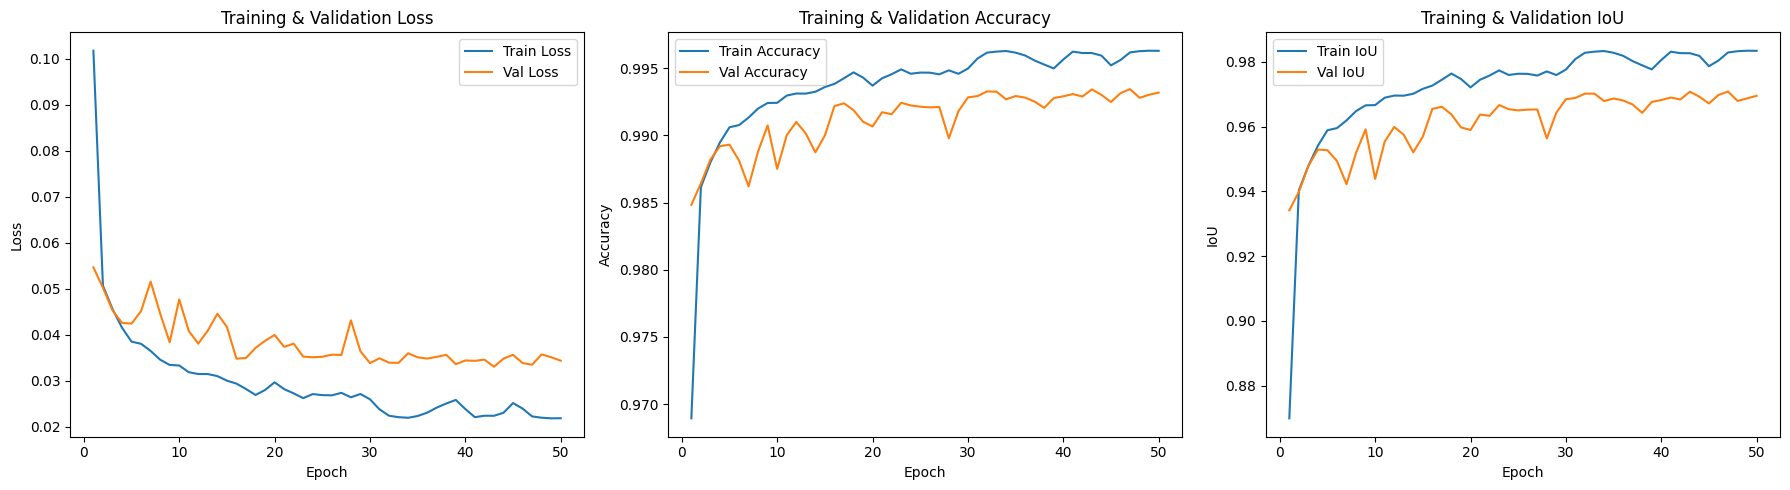

In [9]:
# ========= 训练曲线可视化 ========= #

epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracy_list, label='Train Accuracy')
plt.plot(epochs, val_accuracy_list, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# IoU
plt.subplot(1, 3, 3)
plt.plot(epochs, train_iou_list, label='Train IoU')
plt.plot(epochs, val_iou_list, label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Training & Validation IoU')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
model.save_weights('my_model_weights.weights.h5')
model.save('my_model_full.h5')

/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 786ms/step


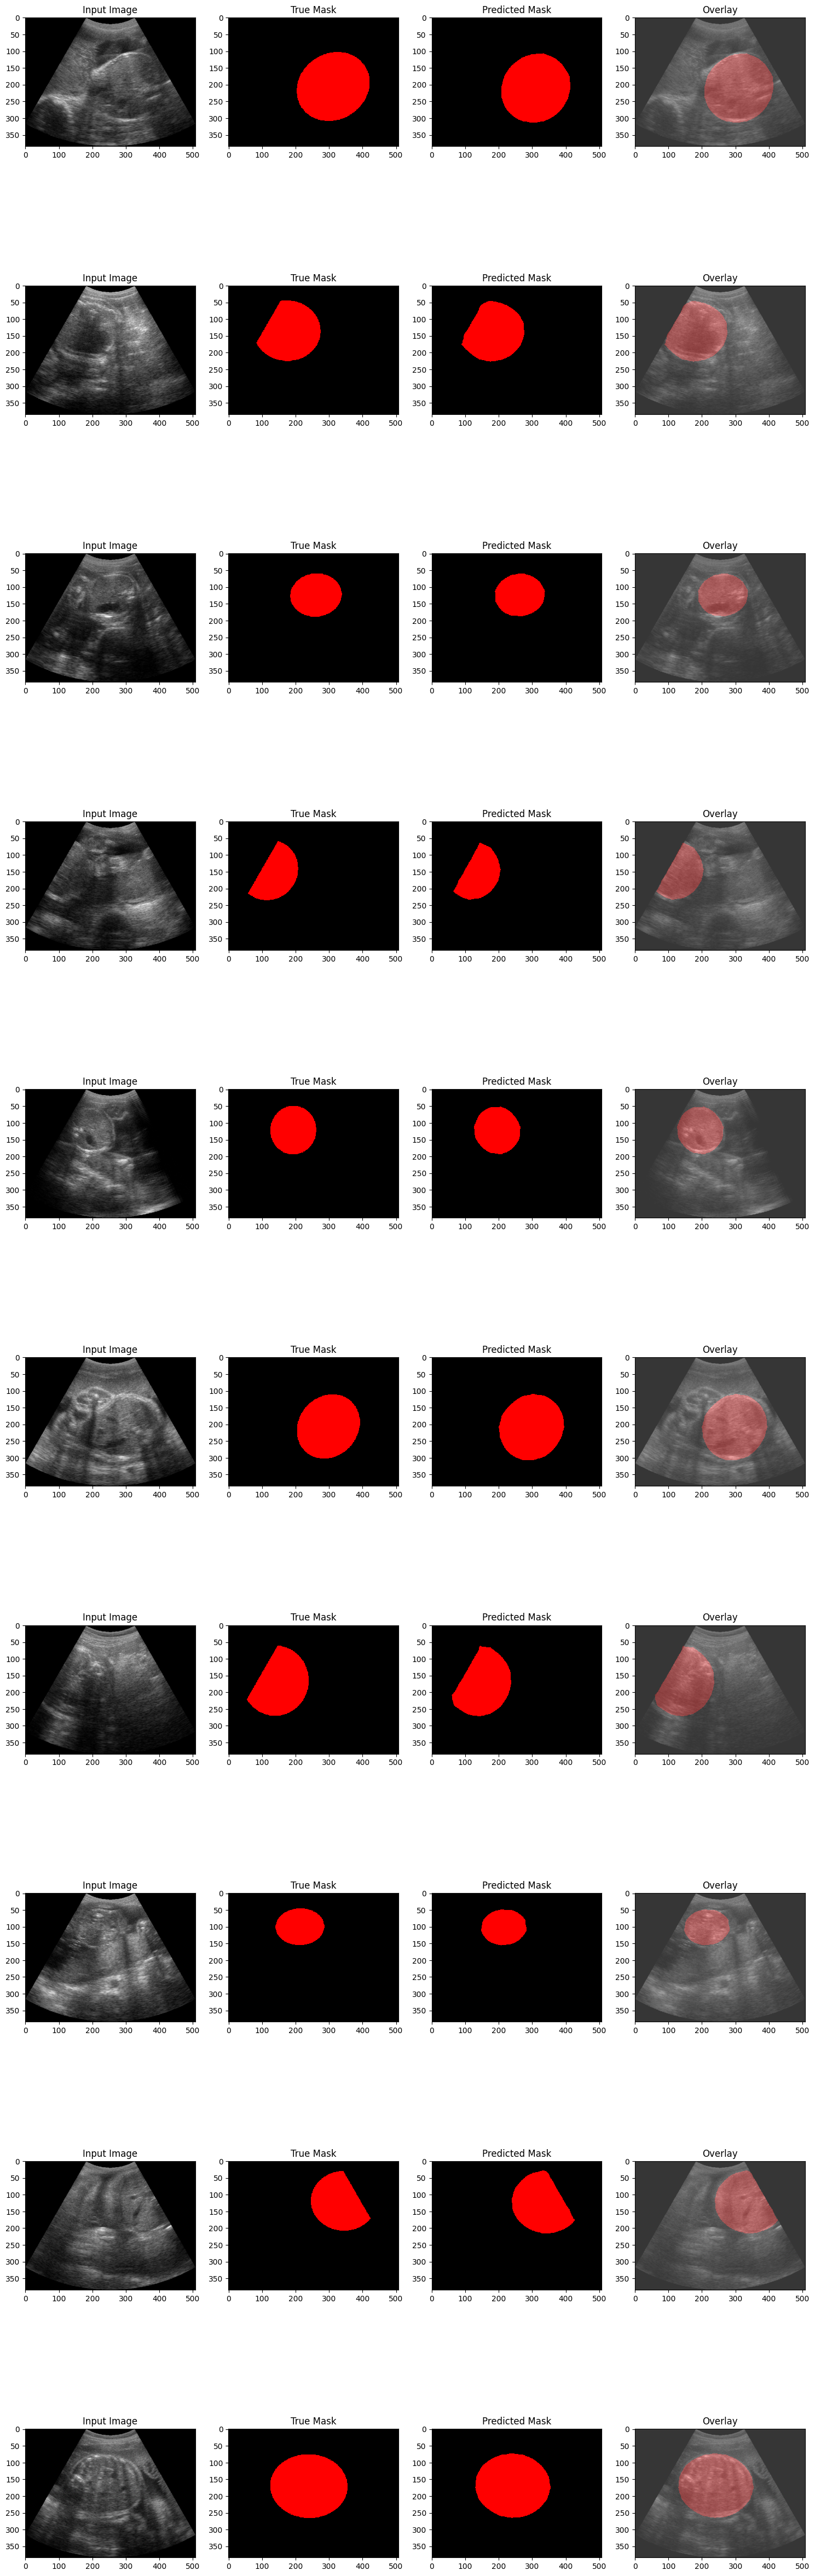

 Evaluation Metrics
Mean IoU   : 0.963267
Accuracy   : 0.99221367
Precision  : 0.975129
Recall     : 0.9581655


In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tensorflow.keras.metrics import MeanIoU, Accuracy, Precision, Recall
import pickle

# with open("weights_tf10_compatible.pkl", "rb") as f:
#     weights = pickle.load(f)
# models.set_weights(weights)
model.load_weights('my_model_weights.weights.h5')


miou_metric = MeanIoU(num_classes=2)
accuracy_metric = Accuracy()
precision_metric = Precision()
recall_metric = Recall()


cmap = ListedColormap(['black', 'green', 'red'])

#  每轮展示多少图像
num = 10

#  从验证集取一个 batch
for image, mask in dataset_test.take(1):
    # 模型预测（logits -> 类别索引）
    logits = model.predict(image)
    pred_mask = tf.argmax(logits, axis=-1)           # (B, H, W)
    pred_mask = pred_mask[..., tf.newaxis]           # (B, H, W, 1) for broadcasting

    # 可视化结果
    fig = plt.figure(figsize=(15, num * 5))

    for i in range(num):
        if mask[i].shape[-1] > 1:
            true_mask = tf.argmax(mask[i], axis=-1)
        else:
            true_mask = tf.squeeze(mask[i])
        true_mask = tf.cast(true_mask, tf.int32)

        pred = tf.squeeze(pred_mask[i])
        pred = tf.cast(pred, tf.int32)

        miou_metric.update_state(true_mask, pred)
        accuracy_metric.update_state(true_mask, pred)
        precision_metric.update_state(true_mask, pred)
        recall_metric.update_state(true_mask, pred)

        plt.subplot(num, 4, i * 4 + 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.title("Input Image")

        plt.subplot(num, 4, i * 4 + 2)
        plt.imshow(true_mask, cmap=cmap, interpolation='nearest')
        plt.title("True Mask")

        plt.subplot(num, 4, i * 4 + 3)
        plt.imshow(pred, cmap=cmap, interpolation='nearest')
        plt.title("Predicted Mask")

        plt.subplot(num, 4, i * 4 + 4)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]), alpha=0.7)
        plt.imshow(pred, cmap=cmap, alpha=0.3, interpolation='nearest')
        plt.title("Overlay")

    plt.tight_layout()
    plt.show()

print(" Evaluation Metrics")
print("Mean IoU   :", miou_metric.result().numpy())
print("Accuracy   :", accuracy_metric.result().numpy())
print("Precision  :", precision_metric.result().numpy())
print("Recall     :", recall_metric.result().numpy())


In [12]:
import tensorflow as tf
from matplotlib.colors import ListedColormap
from tensorflow.keras.metrics import MeanIoU, Accuracy, Precision, Recall

miou_metric = MeanIoU(num_classes=2)
accuracy_metric = Accuracy()
precision_metric = Precision()
recall_metric = Recall()

cmap = ListedColormap(['black', 'green', 'red'])

for image, mask in dataset_test:
    logits = model.predict(image)
    pred_mask = tf.argmax(logits, axis=-1)           # (B, H, W)
    pred_mask = pred_mask[..., tf.newaxis]           # (B, H, W, 1)

    for i in range(image.shape[0]):
        if mask[i].shape[-1] > 1:
            true_mask = tf.argmax(mask[i], axis=-1)
        else:
            true_mask = tf.squeeze(mask[i])
        true_mask = tf.cast(true_mask, tf.int32)

        pred = tf.squeeze(pred_mask[i])
        pred = tf.cast(pred, tf.int32)

        miou_metric.update_state(true_mask, pred)
        accuracy_metric.update_state(true_mask, pred)
        precision_metric.update_state(true_mask, pred)
        recall_metric.update_state(true_mask, pred)

print("\n Evaluation Metrics on Test Set")
print("Mean IoU   :", round(miou_metric.result().numpy(), 4))
print("Accuracy   :", round(accuracy_metric.result().numpy(), 4))
print("Precision  :", round(precision_metric.result().numpy(), 4))
print("Recall     :", round(recall_metric.result().numpy(), 4))


1/1 [==============================] - 0s 239ms/step

 Evaluation Metrics on Test Set
Mean IoU   : 0.9703
Accuracy   : 0.9933
Precision  : 0.9807
Recall     : 0.9663


In [13]:
import tensorflow as tf
from matplotlib.colors import ListedColormap
from tensorflow.keras.metrics import MeanIoU, Accuracy, Precision, Recall
import numpy as np

# with open("weights_tf10_compatible.pkl", "rb") as f:
#     weights = pickle.load(f)
model.load_weights('my_model_weights.weights.h5')

miou_metric = MeanIoU(num_classes=2)
accuracy_metric = Accuracy()
precision_metric = Precision()
recall_metric = Recall()

num_classes = 2
confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

cmap = ListedColormap(['black', 'green', 'red'])

for image, mask in dataset_test:
    logits = model.predict(image)
    pred_mask = tf.argmax(logits, axis=-1)           # (B, H, W)
    pred_mask = pred_mask[..., tf.newaxis]           # (B, H, W, 1)

    for i in range(image.shape[0]):
        if mask[i].shape[-1] > 1:
            true_mask = tf.argmax(mask[i], axis=-1)
        else:
            true_mask = tf.squeeze(mask[i])
        true_mask = tf.cast(true_mask, tf.int32)

        pred = tf.squeeze(pred_mask[i])
        pred = tf.cast(pred, tf.int32)

        miou_metric.update_state(true_mask, pred)
        accuracy_metric.update_state(true_mask, pred)
        precision_metric.update_state(true_mask, pred)
        recall_metric.update_state(true_mask, pred)

        y_true = tf.reshape(true_mask, [-1])
        y_pred = tf.reshape(pred, [-1])
        cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=num_classes).numpy()
        confusion_matrix += cm

dice_per_class = []
for i in range(num_classes):
    TP = confusion_matrix[i, i]
    FP = np.sum(confusion_matrix[:, i]) - TP
    FN = np.sum(confusion_matrix[i, :]) - TP
    denom = 2 * TP + FP + FN
    dice = 2 * TP / denom if denom > 0 else 0.0
    dice_per_class.append(dice)

mean_dice = np.mean(dice_per_class)

print("\n Evaluation Metrics on Test Set")
print("Mean IoU   :", round(miou_metric.result().numpy(), 4))
print("Accuracy   :", round(accuracy_metric.result().numpy(), 4))
print("Precision  :", round(precision_metric.result().numpy(), 4))
print("Recall     :", round(recall_metric.result().numpy(), 4))
print("Dice Coef. :", [f"Class {i}: {round(d, 4)}" for i, d in enumerate(dice_per_class)])
print("Mean Dice  :", round(mean_dice, 4))

1/1 [==============================] - 0s 31ms/step

 Evaluation Metrics on Test Set
Mean IoU   : 0.9703
Accuracy   : 0.9933
Precision  : 0.9807
Recall     : 0.9663
Dice Coef. : ['Class 0: 0.9962', 'Class 1: 0.9734']
Mean Dice  : 0.9848
